### Description

This is notebook implements a basic inverted neuron layer with neuron purging.

### Notes
- The layer initialisation is currently very basic. This should be explored more
- The layer purges routinely (e.g. every 2000 iters). To decide which layer to purge we calculate MSE between all neurons within the layer and purge k neurons with the smallest MSE.

### Findings
- More investigation is needed into whether purging successfully diversifies the patterns recognised within the layer.
- It is possible that a well chosen t_decay will make purging unnecessary.

### Further things to explore
- The `t_decay` value likely needs to be set/scaled proportionally to the number of possible patterns. 
  
  The reason for this is if there are `p` patterns that occur equally often, then there is a `1/p` chance that a neuron will see the pattern it is fitting to. This means there is a `(p-1)/p` chance that the neuron threshold will decay on a given iteration.
  
  One avenue to explore would be an exponential `t_decay` value, or a `t_decay` value which itself decays over time. This will have the effect of 'locking on' to a pattern over time. This however would make neurons less adaptable to new data.

- Use smaller data types (e.g. float16)
- See how well this layer can be optimized for GPU execution
- Compose network of multiple InvertedNeuronLayers
- Freeze layer and train linear regression on top as a classifier

In [65]:
from sklearn.metrics import mean_squared_error
import numpy as np
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import heapq

In [66]:
def simpleMSE(weights: np.ndarray, data: np.ndarray):
    return np.apply_along_axis(
       lambda weight_vec: mean_squared_error(weight_vec, data), 
       1, 
       weights)

neuron1 = [1, 2, 3]
neuron2 = [1, 5, 0]

weights = np.array([neuron1, neuron2])
data = np.array([1, 3, 3])

simpleMSE(weights, data)


array([0.33333333, 4.33333333])

In [82]:
class InvertedNeuronLayer:
    
    T_DECAY_DEFAULT_INITIALIZER = lambda neurons: 1 + np.array(range(1, neurons+1)) / 10000
    W_BOOST_DEFAULT_INITIALIZER = lambda neurons: 1 + np.array(range(1, neurons+1)) / 100
    WEIGHT_DEFAULT_INITIALIZER = lambda neurons, neuron_size: np.array(np.random.rand(neurons, neuron_size))
    THRESHOLD_DEFAULT_INITIALIZER = lambda neurons: np.ones(neurons)
    
    float_type = np.float16
    
    def __init__(self, 
            neurons: int, 
            neuron_size: int, 
            t_decay_init = None, 
            w_boost_init = None, 
            weight_init = None,
            threshold_init = None):
        
        self.neuron_count = neurons
        self.neuron_size = neuron_size

        if weight_init == None:
            weight_init = InvertedNeuronLayer.WEIGHT_DEFAULT_INITIALIZER
        if t_decay_init == None:
            t_decay_init = InvertedNeuronLayer.T_DECAY_DEFAULT_INITIALIZER
        if w_boost_init == None:
            w_boost_init = InvertedNeuronLayer.W_BOOST_DEFAULT_INITIALIZER
        if threshold_init == None:
            threshold_init = InvertedNeuronLayer.THRESHOLD_DEFAULT_INITIALIZER
        
        self.weight_init = weight_init
        self.t_decay_init = t_decay_init
        self.w_boost_init = w_boost_init
        self.threshold_init = threshold_init
        
        self.t = InvertedNeuronLayer.THRESHOLD_DEFAULT_INITIALIZER(neurons)
        self.W = weight_init(neurons, neuron_size)
        self.t_decay = t_decay_init(neurons)
        self.w_boost = w_boost_init(neurons)
        

    def forward(self, data):
        assert len(data.shape) == 1
        assert data.shape[0] == self.neuron_size, f"expected data.shape[0] == {self.neuron_size} but data.shape[0] == {data.shape[0]}"
        
        self.signal = simpleMSE(self.W, data) # n x 1
        
        '''
        Logic:
        - if pattern and neuron weights are similar then signal approaches 0
        - if pattern and neuron weights are different then signal approaches 1
        
        Thus, neuron activation/excitement is redefined as if signal <= threshold
        
        If excited: modify weights to be more similar to input pattern and decrease threshold
        If not excited: increase threshold
        ''' 
        self.excited = self.signal <= self.t # n x 1
        
        self.t = self.t_decay * (self.signal * self.excited + self.t * ~self.excited)
        
        self.W += np.apply_along_axis(lambda col: col * self.excited * self.w_boost, 0, (data - self.W)) # (vec - matrix) is applied row wise by default
        
        return self.signal
    
        
    def purge_layer(self, neurons: int):
        '''
        Purge network of n similar neurons. 
        
        Note, purge_layer will purge at most the specified number of neurons however this is not guaranteed due to the implementation. 
        I did not rectify this as I suspect the impact will be minimal.
        
        Method: 
        Calculate O(2n) array of MSE of all neurons to all other neurons.
        The neurons with the smallest difference to the average should be purged.
        if MSE(neuron1, neuron2) is among the smallest, the decision between purging neuron1 and neuron2 is random.
        '''
        PURGE_HIGHEST_THRESHOLD = True
        
        MSEs = []
        for neuron_index1 in range(len(self.W)):
            min_MSE = float('inf')
            min_MSE_neuron_index2 = neuron_index1 # initialising this as neuron_index1 is to deal with the edge case of a single neuron layer calling purge 
            for neuron_index2 in range(neuron_index1+1, len(self.W)):
                MSE = mean_squared_error(self.W[neuron_index1], self.W[neuron_index2])
                if MSE < min_MSE:
                    min_MSE = MSE
                    min_MSE_neuron_index2 = neuron_index2
            
            MSEs.append((min_MSE, neuron_index1, min_MSE_neuron_index2))
        
        min_MSEs = heapq.nsmallest(neurons, MSEs, key = lambda triple: triple[0])
        
        if not PURGE_HIGHEST_THRESHOLD:
            # randomly chooses which neuron to remove from the k smallest MSE
            rand_index_selector = np.random.randint(2, size=len(min_MSEs)) + 1 
            min_MSE_indices = {pair[rand_index_selector[i]] for i, pair in enumerate(min_MSEs)}
            self._reinit_neurons(min_MSE_indices)
            
        else: 
            # purge neuron with higher threshold to increase chance of preserving pattern in lower threshold neuron
            min_MSE_indices = {pair[1] if self.t[pair[1]] > self.t[pair[2]] else pair[2] for pair in min_MSEs}
            self._reinit_neurons(min_MSE_indices)
        
    def _reinit_neurons(self, neuron_indices: list):
        for neuron_index in neuron_indices:
            self.W[neuron_index] = self.weight_init(1, self.neuron_size)
            self.t[neuron_index] = self.threshold_init(1)
            self.t_decay[neuron_index] = self.t_decay_init(1)
            self.w_boost = self.w_boost_init(1)


In [68]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_data = mnist_trainset.train_data.cpu().detach().numpy()
mnist_data;

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


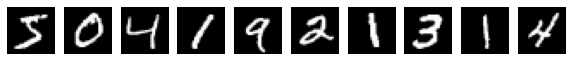

In [69]:
# plot the 2D matrix heatmap
# supports a 2D array, or flattened (uses DIMS to restore 1D to 2D)
def draw_digits(dims, *data):
    PLOTS_PER_ROW = 20
    cols = min(len(data), PLOTS_PER_ROW)
    rows = math.ceil(len(data)/PLOTS_PER_ROW)
    fig = plt.figure(figsize=(cols,rows))
    for i, digit_array in enumerate(data):
        if digit_array.shape != dims:
            digit_array = np.reshape(digit_array, dims)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(digit_array, cmap='gray')
        plt.axis('off')
    plt.show()

# draw a bunch
draw_digits((28,28), *mnist_data[:10])

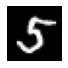

In [72]:
def get_random_mnist_digit(): 
    index = np.random.randint(0, len(mnist_data))
    return mnist_data[index]

def get_random_mnist_digit_crop():
    digit = get_random_mnist_digit()
    

temp = get_random_mnist_digit()
draw_digits((28,28), temp)

Neurons' weights at init:


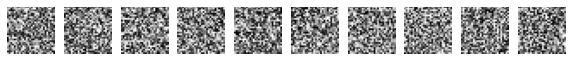


 --- Iter #0 --- 
Neurons' weights pre purge:


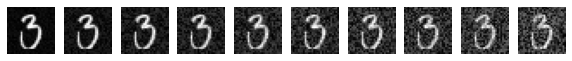

Threshold:
[0.31908955 0.30939679 0.33131464 0.32726754 0.30150546 0.3250467
 0.33394556 0.3438239  0.31701025 0.31931244] float64
Neurons' weights post purge:


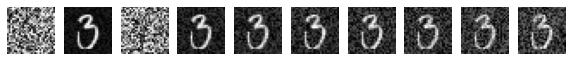


 --- Iter #4000 --- 
Neurons' weights pre purge:


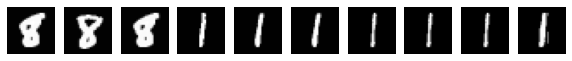

Threshold:
[3.10147104e-04 3.54613716e-04 3.10147104e-04 2.25832176e-04
 1.74684182e-04 1.84426281e-04 9.26174700e-05 9.89117929e-05
 1.05633187e-04 2.20908253e-04] float64
Neurons' weights post purge:


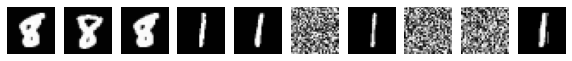


 --- Iter #8000 --- 
Neurons' weights pre purge:


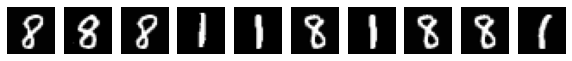

Threshold:
[2.26339702e-04 5.10732256e-08 2.26339702e-04 1.75081334e-04
 1.96730280e-04 4.53122317e-04 2.07440566e-04 4.53122317e-04
 4.53122317e-04 4.16684312e-04] float64
Neurons' weights post purge:


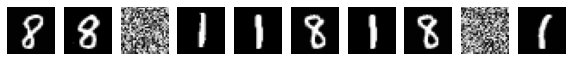


 --- Iter #12000 --- 
Neurons' weights pre purge:


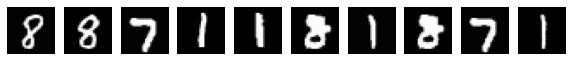

Threshold:
[3.37652405e-04 1.13656462e-07 1.77816034e-04 1.35155677e-04
 1.23877171e-04 4.26105715e-04 2.54091836e-04 4.26105715e-04
 1.77816034e-04 3.09989878e-04] float64
Neurons' weights post purge:


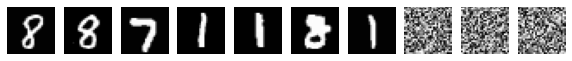


 --- Iter #16000 --- 
Neurons' weights pre purge:


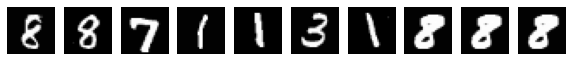

Threshold:
[4.12380610e-04 2.52926876e-07 2.44127720e-04 2.95664561e-04
 2.13874900e-04 3.37381228e-04 2.17346231e-04 1.76518864e-04
 1.76518864e-04 1.76518864e-04] float64
Neurons' weights post purge:


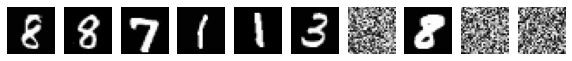


 --- Iter #20000 --- 
Neurons' weights pre purge:


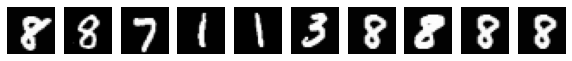

Threshold:
[3.69578179e-04 5.62854091e-07 1.68524875e-04 1.28349665e-04
 4.75567798e-08 3.40915054e-04 2.99819145e-04 2.63329935e-04
 2.99819145e-04 2.99819145e-04] float64
Neurons' weights post purge:


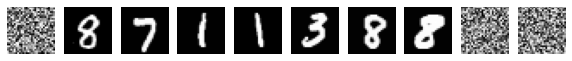


 --- Iter #24000 --- 
Neurons' weights pre purge:


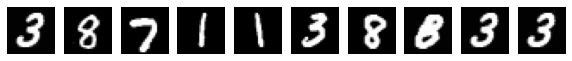

Threshold:
[2.44787981e-04 1.25255462e-06 2.41453288e-04 1.44876606e-04
 3.51224116e-07 4.07248860e-08 3.91335843e-08 3.14700575e-04
 2.44787981e-04 2.44787981e-04] float64
Neurons' weights post purge:


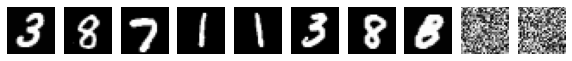


 --- Iter #28000 --- 
Neurons' weights pre purge:


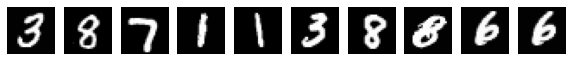

Threshold:
[3.46306069e-04 2.78738860e-06 2.56484946e-08 1.44513826e-04
 2.59391785e-06 6.07531757e-08 5.83792801e-08 4.24195966e-04
 4.10822865e-04 4.10822865e-04] float64
Neurons' weights post purge:


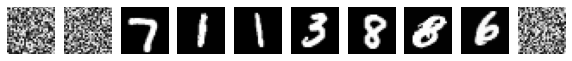


 --- Iter #29999 --- 
Neurons' weights:


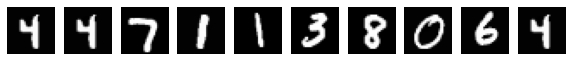

Threshold:
[4.88531250e-04 4.88531250e-04 2.30183170e-12 2.23700902e-04
 7.04571495e-06 7.41959348e-08 7.12967710e-08 4.74629599e-04
 1.51247936e-04 4.88531250e-04] float64


In [86]:
'''NOTE:
Threshold starting at 1 means patterns with larger pixel values will take significantly longer to learn as the threshold has to degrade
e.g.
pattern = np.array([
    [25,0,0,0,0,0,1],
    [0,2,0,0,0,1,0],
    [0,0,1,0,1,0,0],
    [0,0,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,0,0,1,0],
    [1,0,0,0,0,0,1]])
    
Also with low learning rate, the layer with initial threshold seems to consistently learn "1"

This could be addressed by better selection of hyperparams or by normalising the input in some way.
'''

ITERS = 30000
PURGE_INTERVAL = 4000
PURGE_NEURON_COUNT = 3
# Throw in some noise inputs 
# (without noise at zero, it converges very quickly - noise rate increases slows down learning exponentially!)
NEURONS = 10
INPUT_DIMS = (28,28)
NEURON_SIZE = np.prod(INPUT_DIMS)

layer = InvertedNeuronLayer(NEURONS, NEURON_SIZE)

print("Neurons' weights at init:")
draw_digits(INPUT_DIMS, *[neuron for neuron in layer.W])

for i in range(ITERS):
    digit = get_random_mnist_digit()
    digit = digit / np.linalg.norm(digit)
        
    out = layer.forward(digit.reshape((np.prod(digit.shape),)))
         
    if i % PURGE_INTERVAL == 0:
        print(f"\n --- Iter #{i} --- ")
        print("Neurons' weights pre purge:")
        draw_digits(INPUT_DIMS, *[neuron for neuron in layer.W])
        print("Threshold:")
        print(layer.t)
        
        layer.purge_layer(PURGE_NEURON_COUNT)
        
        print("Neurons' weights post purge:")
        draw_digits(INPUT_DIMS, *[neuron for neuron in layer.W])

print(f"\n --- Iter #{i} --- ")
print("Neurons' weights:")
draw_digits(INPUT_DIMS, *[neuron for neuron in layer.W])
print("Threshold:")
print(layer.t)
